In [1]:
import torch
from torch.nn import CrossEntropyLoss, Softmax

import transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer

#Datahandeling
import numpy as np
import pandas as pd
import datasets
from datasets import Dataset
import spacy


# Evaluation
import sklearn
from sklearn.metrics import classification_report,confusion_matrix

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import bertviz
from bertviz import head_view,model_view
import transformers_interpret
from transformers_interpret import MultiLabelClassificationExplainer

#Utils
import os
import TeXTableUtil
import gc

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce GTX 1060 3GB


## Load Data and Last Model

In [3]:
train_test_ds= datasets.load_from_disk(os.path.abspath("../data/processed_data")) #load in the tokenized dataset
base_data = pd.read_csv("../data/labeled_data.csv") #load in the raw data to concat later

In [4]:
TOKEN_PATH = r"../data/token"
MODEL_ARCHITECTURE = 'distilbert-base-uncased' 
checkpoint_number = 7000
CHK_DIR = r"../results/checkpoint-{}".format(checkpoint_number)
LAST_MODEL = r"../results/training_begin=20220312-202358"
#"../results/last-model" 
#different types of model to load up 

tokenizer = AutoTokenizer.from_pretrained(TOKEN_PATH) #declare tokenizer via path
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path="../results/model")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [5]:
#import pickle
#with open(LAST_MODEL+"/training_args", 'rb') as f:
#    x = pickle.load(f)
#print(x)

In [6]:
training_args = TrainingArguments(output_dir = ".")

# this is kind of an abuse of the Trainingclass to do the prediction on the entire test-data batched with calculation of metrics
# But to be honest, it's not too bad and it is quick
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test_ds["train"],
    eval_dataset=train_test_ds["train"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

eval_ds = datasets.concatenate_datasets([train_test_ds['train'], train_test_ds['test']])
print(eval_ds)

predictions = trainer.predict(eval_ds) #generate predictions on the test set


The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet.
***** Running Prediction *****
  Num examples = 24783
  Batch size = 8


Dataset({
    features: ['labels', 'tweet', 'input_ids', 'attention_mask'],
    num_rows: 24783
})


100%|██████████| 3098/3098 [08:27<00:00,  6.46it/s]

In [7]:

print(predictions.predictions.shape, predictions.label_ids.shape)

y_pred = np.argmax(predictions.predictions, axis=-1)
y_true = predictions.label_ids

output = predictions.predictions

(24783, 3) (24783,)


#### GPU - Flushing
The Cell below is used for VRAM Flushing so that CUDA Out of Memory errors do not occure or can be solved without restarting the kernel.
Sometimes if a cell errors the VRAM can't be appropriately cleared by torch which is when one needs to uncomment the 1/0 to cause an arithmetic error which unlocks the vram to be cleared by torch commands.
It's a very useful hack from StackOverflow, i'll include the link to the threat if I find it.


In [8]:
gc.collect()
torch.cuda.empty_cache()
#1/0

## Build Exploration Dataframes.
In this part of the notebook we construct dataframes to aid investigation into confusion of the model and looking at overall performance.

### String Preprocessing

In [9]:

nlp = spacy.load("en_core_web_sm") #using the small english component since it has good performance and is very quick
ruler = nlp.add_pipe("entity_ruler",config = {"overwrite_ents": True}) # Add an EnitiyRuler Component to the Pipeline and overwrite predefined Ents so only the below specified patterns are recognized

# general structure of a spacy pattern is {label:LABEL_NAME, pattern = [{pattern_type:pattern_string},{},...{}] list of subpatterns, id:ID_STRING } 
patterns = [
                {"label": "[URL]", "pattern": [{"TEXT":{"REGEX":'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'}}], "id":"url"}, # url pattern
                {"label": "[MENTION]", "pattern": [ {"TEXT":{"REGEX":"@[\w\-]+"}}], "id":"ment"}, #twitter mentions pattern
                {"label": "[WHITESPACE]", "pattern": [ {"TEXT":{"REGEX":"\s+"}}], "id":"ws"} # whitespace pattern
            ]

ruler.add_patterns(patterns) # add the above defined patterns to ruler-object 
print("ENTITY IDS = ",ruler.ent_ids) 

def preprocess_tweet(text_string:str) -> str: 
    doc = nlp(text_string) # runs the spacy pipeline over the input-string and returning a doc object which incorperates a tokenization, postagging, lemmatization and the regex as entities via the EntityRuler component
    out_string = "" 
    for token in doc: # iterate over all tokens in the document
        if token.ent_id_ == "": # is the token an entitiy of Null-Type (thus not a url,a mention or whitespace) then lemmatize it 
            out_string = out_string + " " + token.lemma_
        else:
            if token.ent_id_ == "ws": # is the token just whitespace then forget the token (we don't want uneccesary whitespace)
                pass
            else: # otherwise the token has to be a mention or a url so just append the name of the entity-type (to normalize them for the subword tokenizer)
                out_string = out_string + " " + token.ent_type_
    return out_string

ENTITY IDS =  ('ws', 'ment', 'url')


### Building the Dataframes for Data Exploration

In [10]:
analysis_df  = pd.DataFrame(data=output,columns=["hate_out","offensive_out","neither_out"]) # use logits as initial data 
analysis_df["tweets"] = eval_ds[analysis_df.index]["tweet"] # map appropriate tweet data using the dataframe indexing
analysis_df["label"] = y_true # add gold-label
analysis_df["pred_label"] = y_pred # add predicted label

softmax = Softmax(dim=1) 
input = torch.as_tensor(analysis_df[["hate_out","offensive_out","neither_out"]].values) # cast the logits into torch.Tensor datatype as expected by the torch Softmax function
analysis_df[["hate_%","offensive_%","neither_%"]] = np.array(softmax(input)) # add softmax-output as columns which showcase how likely the model thinks each class is

analysis_df.head()


,hate_out,offensive_out,neither_out,tweets,label,pred_label,hate_%,offensive_%,neither_%
0,-1.442401,3.794643,-2.775381,RT @ChickenColeman: I need some hoes man real ...,1,1,0.005280,0.993327,0.001392
1,-0.677587,3.318845,-3.330582,Stupid hoe is so wack &#127926;&#128526;,1,1,0.018026,0.980704,0.001270
2,-2.615921,-1.383314,4.801140,RT @ManiChakr: @ArvindKejriwal itni bahaduri!!...,2,2,0.000599,0.002056,0.997345
3,2.274735,0.590436,-4.121693,@mjs79 @ChingonAbe well he is at Genos. So he ...,0,0,0.842288,0.156307,0.001405
4,0.150976,2.529336,-3.794327,The lies on this here Twitter &#8220;@Libra_DT...,1,1,0.084699,0.913663,0.001639


In [11]:
class_weights = (1- (base_data["class"].value_counts().sort_index()/len(base_data))).values #calculate the class weights to balance the loss to the rarer classes
class_weights = torch.from_numpy(class_weights).float() # cast into torch tensor
loss = CrossEntropyLoss(weight=class_weights) # define loss function to calculate loss on the output to see which examples cause the largest loss

In [12]:
def row_loss(row: np.array) -> np.float: # Function that calculates loss for each row
    # this is far from an ideal solution and pretty slow but since the output is ~2700 rows it is fine to be a bit slow. If you wanna scale up the Data refactor this!!
    input = torch.as_tensor([list(row[["hate_out","offensive_out","neither_out"]].values)])
    target = torch.tensor(data=[int(row["label"])], dtype=torch.long)
    return np.float(loss(input,target))

analysis_df["loss"] = analysis_df.apply(lambda row:row_loss(row),axis=1) # apply the row_loss function to every row of the dataframe to define a column with the appropriate loss-value


C:\Users\MEGAPORT\AppData\Local\Temp/ipykernel_5924/3838334035.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def row_loss(row: np.array) -> np.float: # Function that calculates loss for each row
C:\Users\MEGAPORT\AppData\Local\Temp/ipykernel_5924/3838334035.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(loss(inp

In [13]:
confusion_df = analysis_df[analysis_df.label != analysis_df.pred_label] 
#this dataframe is used to see for which predictions the model was wrong and to investigate the appropriate tweets and stats
confusion_df.head() 

,hate_out,offensive_out,neither_out,tweets,label,pred_label,hate_%,offensive_%,neither_%,loss
22,1.721586,0.981368,-3.988201,you niggers cheat on ya gf's? smh....,1,0,0.675528,0.322234,0.002238,1.132479
40,-2.753781,-1.056974,4.396954,RT @Shawnzie3: Foxtrot\nUniform\nCharlie\nKilo.,1,2,0.000780,0.004258,0.994962,5.458979
43,1.947764,0.764006,-3.892901,"seriously, who cares what color somebody is? t...",1,0,0.763923,0.233857,0.002221,1.453047
44,1.361269,-0.401410,-1.506112,@TheREALJB1RD Now beaners drive em.,1,0,0.814046,0.139678,0.046277,1.968417
62,2.154328,0.588455,-4.067716,@Pretty_WarZone shouldve caught it the first t...,1,0,0.825838,0.172522,0.001639,1.757229


## Caluculate Metrics
In this part of the notebook we evaluate the model perfomance and calculate metrics to see how the overall performance turned out.

### Classification Report

In [14]:
report = classification_report(y_true, y_pred )
print(report)


              precision    recall  f1-score   support

           0       0.56      0.71      0.63      1430
           1       0.97      0.95      0.96     19190
           2       0.94      0.97      0.95      4163

    accuracy                           0.94     24783
   macro avg       0.83      0.88      0.85     24783
weighted avg       0.94      0.94      0.94     24783



In [15]:
TeXTableUtil.report_to_LaTeX(report=report,table_name="model_table",mode="save") #saves the report as a latex table 

### Confusion Matrix

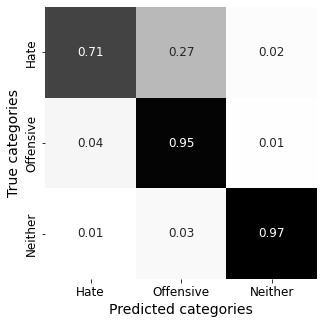

In [ ]:
cm = confusion_matrix(y_true = y_true,y_pred=y_pred)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
names=['Hate','Offensive','Neither']
cm = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12) # this only renders the confusion matrix

#plt.savefig('../report/tables-figures/model_confusion.jpg')

### Value Distributions

array([[<AxesSubplot:title={'center':'pred_label'}>,
        <AxesSubplot:title={'center':'label'}>]], dtype=object)

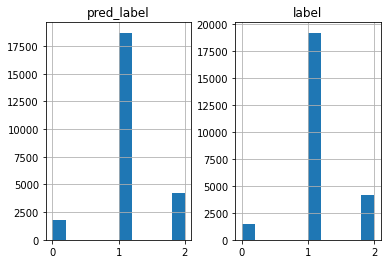

In [ ]:
analysis_df[["pred_label","label"]].hist() #both frequencies are not a terrible missmatch, just a basic sanity check

## Data Exploration and Confusion Investigation

### Investigating High Loss Tweets

In [16]:
def get_top_loss(top_n:int) -> pd.DataFrame: 
    # gets you the df with the n entries with the highest loss values
    loss_df = analysis_df.sort_values(by="loss",ascending=False) # sorts the dataframe by the lossvalues in descending order
    return loss_df.head(top_n) 

def print_top_loss_tweets(top_n:int): 
    #prints out the information and the tweet top_n tweets with the highest loss
    loss_df = get_top_loss(top_n)

    loss = list(loss_df.loss.values) 
    tweets = list(loss_df.tweets.values)
    val2class = {0:"hateful",1:"offensive",2:"neither"} # mapping the class-numbers to the class-names
    labels = [val2class[label] for label in list(loss_df.label.values)] 
    preds = [val2class[label] for label in list(loss_df.pred_label.values)]
    index = list(loss_df.index)

    for i,tweet in enumerate(tweets): # iterate over all tweets and save the index to print appropriate information
        print("TWEET:", "PRED_LABEL:",preds[i], "LABEL:",labels[i] ,"LOSS:",loss[i]," INDEX:",index[i])
        print(tweet)
        print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")

print_top_loss_tweets(100)

TWEET: PRED_LABEL: neither LABEL: hateful LOSS: 7.812115669250488  INDEX: 1728
looking like a hillbilly and not matching is what I do best goodnight losers http://t.co/caGHBLKAXQ
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
TWEET: PRED_LABEL: neither LABEL: hateful LOSS: 7.680166244506836  INDEX: 10557
@Flow935 jus wanted to let y&#225;ll know hope the hurricane kills your soca sunday trash #LORDWILLIN
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
TWEET: PRED_LABEL: offensive LABEL: neither LOSS: 7.05551815032959  INDEX: 1697
Frustration can be a bitch !
--------------------------------------------------------------------------------------------------------

<AxesSubplot:>

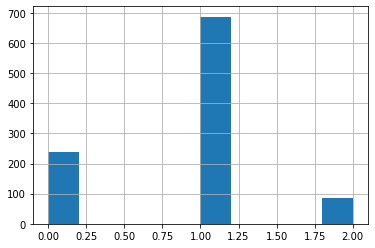

In [17]:
certainty= 0.9 
uncertain_df = confusion_df[(confusion_df["hate_%"] < certainty) & (confusion_df["offensive_%"] < certainty) & (confusion_df["neither_%"] < certainty)]
# this query finds labels where the model was uncertain (it was less than 90% confident in any prediction)
uncertain_df.label.hist() # for example for investigations like this where we can see that the model is more uncertain about gold-hateful tweets

In [18]:
confused_hateful_tweets = confusion_df[(confusion_df.label == 0) & (confusion_df.pred_label != 0)].tweets #finds gold = hate pred =/= hate entries

## Sailence Scores

In [19]:
analysis_df[(analysis_df["hate_%"] < 0.9) & (analysis_df.label == 0)] #which hateful tweets were the model more unsure about

,hate_out,offensive_out,neither_out,tweets,label,pred_label,hate_%,offensive_%,neither_%,loss
3,2.274735,0.590436,-4.121693,@mjs79 @ChingonAbe well he is at Genos. So he ...,0,0,0.842288,0.156307,0.001405,0.171633
47,2.503036,0.372079,-4.344579,@CrackerJhak Because you're a fag,0,0,0.893028,0.106024,0.000948,0.113137
91,0.862395,1.574207,-3.606588,Boy Yung thug is a fag,0,1,0.327961,0.668281,0.003758,1.114860
130,1.405265,1.622608,-4.318678,My nig jus said ain't nuttin worse den a fat l...,0,1,0.445229,0.553317,0.001454,0.809167
131,-1.262025,0.147409,1.437437,@asshole_king pats owner is a kike.,0,2,0.050087,0.205037,0.744876,2.993999
...,...,...,...,...,...,...,...,...,...,...
24709,-1.196790,-0.943132,2.455717,Already more yellows than the last 2 years com...,0,2,0.024474,0.031540,0.943986,3.710150
24716,0.945371,1.558400,-3.703087,RT @JHarmelink182: The fox says you're a cunt.,0,1,0.350190,0.646456,0.003354,1.049279
24717,0.599423,2.431840,-4.264883,I like how niggas try an come at me and im lik...,0,1,0.137804,0.861133,0.001063,1.981924
24762,2.361853,0.389736,-4.089727,See&gt; Its a FINE LINE&gt; Killing #faggots d...,0,0,0.876624,0.121993,0.001383,0.131677


In [20]:
id = 3 # index of tweet I wanna investigate
class2label = {0:"hateful",1:"offensive",2:"neither"}
input_text = analysis_df["tweets"].loc[id]
multiclass_explainer = MultiLabelClassificationExplainer(model=model, tokenizer=tokenizer) # helper class to explain multiclass descisions by the bert model
word_attributions = multiclass_explainer(text=input_text)


In [21]:
# This cell renders the saliency scores calculated in Captum if html_filepath is given you can save the html at the path
html = multiclass_explainer.visualize()#html_filepath = "racism.html") 
print("LABEL:",class2label[analysis_df.label.iloc[id]]) 
print("PRED LABEL:" ,class2label[analysis_df.pred_label.iloc[id]])

LABEL: hateful
PRED LABEL: hateful


## BERT Visualization

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path="../results/model",output_attentions = True) #redefine model since the below listed models need output_attentions = True

loading configuration file ../results/model\config.json
Model config DistilBertConfig {
  "_name_or_path": "../results/last-model",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_attentions": true,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.12.5",
  "vocab_size": 30522
}

loading weights file ../results/model\pytorch_model.bin
All model checkpoint weights were used when initializing Dist

In [ ]:
input_text = analysis_df["tweets"].loc[4301] # tweet I wanna investigate
inputs = tokenizer.encode(preprocess_tweet(input_text), return_tensors='pt')  # Tokenize input text 
outputs = model(inputs)  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings

head_view(attention, tokens)  # Display model view

<IPython.core.display.Javascript object>

In [ ]:

model_view(attention,tokens)

<IPython.core.display.Javascript object>